In [1]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.petri.importer import importer as pnml_importer
from pm4py.objects.petri.exporter import exporter as pnml_exporter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petrinet import visualizer as pn_visualizer

import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree, tostring
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

In [2]:
xmlns = '{http://www.yawlfoundation.org/yawlschema}'

class Yawl:
    def __init__(self, file):
        self.root = ET.parse(file).getroot()
        self.specification = self.root.find(xmlns + 'specification')
        self.layout = self.root.find(xmlns + 'layout')
        
        self.decomposition = self.specification.find(xmlns + 'decomposition')
        
        self.conditions = self.decomposition[0].findall(xmlns + 'condition')
        self.tasks = self.decomposition[0].findall(xmlns + 'task')
        self.inputCondition = self.decomposition[0].find(xmlns + 'inputCondition')
        self.outputConditions = self.decomposition[0].findall(xmlns + 'outputCondition')
        
        self.allElements = self.conditions + self.tasks + [self.inputCondition] + self.outputConditions
        
        
    
yawl = Yawl('credit-card-demo.yawl')

In [3]:
#place {id: string, initialMarking: boolean}
#transition {id: string, targets: string[], sources: string[], split: string, join: string}
#arc {id: string, source: string, target: string}

class Pnml:
    def __init__(self, places, transitions, arcs):
        self.root = ET.Element('pnml')
        
        self.net = ET.SubElement(self.root, 'net')
        self.net.set('id', 'net1')
        self.net.set('type', 'http://www.pnml.org/version-2009/grammar/pnmlcoremodel')
        
        self.page = ET.SubElement(self.net, 'page')
        self.page.set('id', 'n0')
        
        for place in places:
            placeElement = ET.SubElement(self.page, 'place')
            placeElement.set('id', place['id'])
            placeElementName = ET.SubElement(placeElement, 'name')
            placeElementNameText = ET.SubElement(placeElementName, 'text')
            placeElementNameText.text = place['id']
            
            if place['initialMarking']:
                initialMarking = ET.SubElement(placeElement, 'initialMarking')
                initialMarkingText = ET.SubElement(initialMarking, 'text')
                initialMarkingText.text = '1'
                
        for transition in transitions:
            transitionElement = ET.SubElement(self.page, 'transition')
            transitionElement.set('id', transition['id'])
            transitionElementName = ET.SubElement(transitionElement, 'name')
            transitionElementNameText = ET.SubElement(transitionElementName, 'text')
            transitionElementNameText.text = transition['id']
            
        for arc in arcs:
            arcElement = ET.SubElement(self.page, 'arc')
            arcElement.set('id', arc['id'])
            arcElement.set('source', arc['source'])
            arcElement.set('target', arc['target'])
            
            
    def writePnml(self, filePath):
        fileBytes = tostring(self.root)
        file = open(filePath, 'wb')
        file.write(fileBytes)
        file.close()
            

{'id': 'place_C', 'initialMarking': False}
['C', 'Check_completeness']
{'id': 'place_Receive_application', 'initialMarking': False}
['Receive_application']
{'id': 'place_Cancel', 'initialMarking': False}
['Cancel', 'Hold']
{'id': 'place_Check_completeness', 'initialMarking': False}
['C', 'Check_completeness']
{'id': 'place_Hold', 'initialMarking': False}
['Cancel', 'Hold']
{'id': 'place_Check_credit_Bureau', 'initialMarking': False}
['Check_document', 'Check_credit_Bureau']
{'id': 'place_Check_document', 'initialMarking': False}
['Check_document', 'Check_credit_Bureau']
{'id': 'place_Collect_results', 'initialMarking': False}
['Collect_results']
{'id': 'place_Collect_results', 'initialMarking': False}
['Collect_results']
{'id': 'place_Make_decision', 'initialMarking': False}
['Make_decision']
{'id': 'place_Approve', 'initialMarking': False}
['Reject', 'Approve']
{'id': 'place_Reject', 'initialMarking': False}
['Reject', 'Approve']
{'id': 'place_Want_extra_package', 'initialMarking': Fa

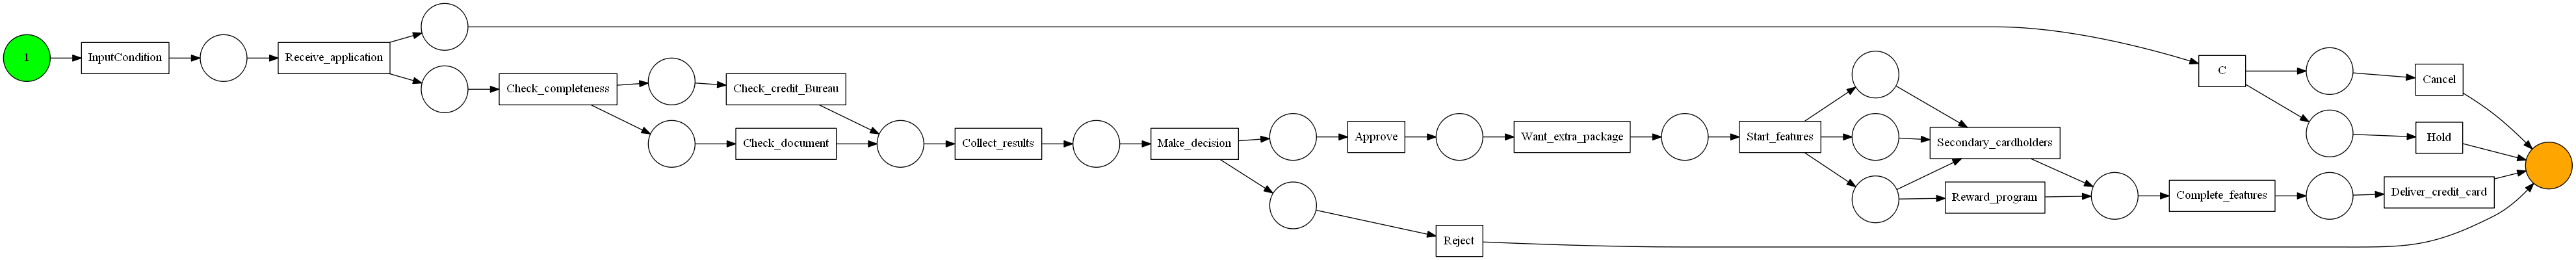

In [144]:
places = []
transitions = []
arcs = []

yawl = Yawl('credit-card-demo.yawl')

#Create all conditions and task's places
conditionID = yawl.inputCondition.attrib['id']

places.append({'id': 'place_' + conditionID, 'initialMarking': True})
transitions.append({'id': conditionID, 'sources': [], 'targets': [], 'split': 'none', 'join': 'none'})
arcs.append({'id': '0', 'source': 'place_' + conditionID, 'target': conditionID})

i = 1
for condition in yawl.conditions:
    conditionID = condition.attrib['id']

    places.append({'id': 'place_' + conditionID, 'initialMarking': False})
    transitions.append({'id': conditionID, 'sources': [], 'targets': [], 'split': 'none', 'join': 'none'})
    arcs.append({'id': str(i), 'source': 'place_' + conditionID, 'target': conditionID})
    
    i += 1
    
for task in yawl.tasks:
    taskID = task.attrib['id']
    places.append({'id': 'place_' + taskID, 'initialMarking': False})
    taskJoin = task.find(xmlns + 'join').attrib['code']
    taskSplit = task.find(xmlns + 'split').attrib['code']
    transitions.append({'id': taskID, 'sources': [], 'targets': [], 'split': taskSplit, 'join': taskJoin})
    arcs.append({'id': str(i), 'source': 'place_' + taskID, 'target': taskID})
    
    i += 1

for outputCondition in yawl.outputConditions:
    conditionID = outputCondition.attrib['id']

    places.append({'id': 'place_' + conditionID, 'initialMarking': False})
    transitions.append({'id': conditionID, 'sources': [], 'targets': [], 'split': 'none', 'join': 'none'})
    arcs.append({'id': str(i), 'source': 'place_' + conditionID, 'target': conditionID})

    i += 1

#Get targets and sources
for transition in transitions:
    #Get transition's targets
    for element in yawl.allElements:
        if element.attrib['id'] == transition['id']:
            break
    elementFlowsIntos = element.findall(xmlns + 'flowsInto')
    for elementFlowsInto in elementFlowsIntos:
        nextElementRef = elementFlowsInto.find(xmlns + 'nextElementRef')
        transition['targets'].append(nextElementRef.attrib['id'])

    #Get transition's sources
    for element in yawl.allElements:
        elementFlowsIntos = element.findall(xmlns + 'flowsInto')
        for elementFlowsInto in elementFlowsIntos:
            nextElementRef = elementFlowsInto.find(xmlns + 'nextElementRef')
            if nextElementRef.attrib['id'] == transition['id']:
                transition['sources'].append(element.attrib['id'])
#Connect arcs
for transition in transitions:
    if transition['split'] == 'none':
        for source in transition['sources']:
            arcs.append({'id': str(i), 'source': source, 'target': 'place_' + transition['id']})
            i += 1
        for target in transition['targets']:
            arcs.append({'id': str(i), 'source': transition['id'], 'target': 'place_' + target})
            i += 1

    if transition['split'] == 'xor':
        for target in transition['targets']:
            arcs.append({'id': str(i), 'source': transition['id'], 'target': 'place_' + target})
            i += 1

    if transition['split'] == 'and':
        for target in transition['targets']:
            arcs.append({'id': str(i), 'source': transition['id'], 'target': 'place_' + target})
            i += 1

    if transition['split'] == 'or':
        nPlaces = 2 ** len(transition['targets']) - 1
        transitionPlaces = []
        for j in range(nPlaces):
            placeName = 'place_' + transition['id'] + '_' + str(j)
            place = {'id': placeName, 'initialMarking': False}
            places.append(place)
            arcs.append({'id': str(i), 'source': transition['id'], 'target': placeName})
            i += 1
            transition['targets'].append(placeName)

            k = 0
            for char in bin(j + 1)[2:]:
                if char == '1':
                    arcs.append({'id': str(i), 'source': placeName, 'target': transition['targets'][k]})
                    i += 1
                    for target in transitions:
                        if target['id'] == transition['targets'][k]:
                            break
                    target['sources'].append(placeName)
                k += 1
            transitionPlaces.append(place)
        transition['targets'] = []
        
        


#Delete output transitions
for transition in transitions:
    if transition['split'] == 'none' and len(transition['targets']) == 0:
        transitions.remove(transition)

#Delete repeated arcs
repeatedArcs = []
arcsToIgnore = []
for arc1 in arcs:
    if arc1 not in arcsToIgnore:
        arcsWithoutArc1 = arcs.copy()
        arcsWithoutArc1.remove(arc1)
        for arc2 in arcsWithoutArc1:
            if arc1['source'] == arc2['source'] and arc1['target'] == arc2['target']:
                repeatedArcs.append(arc2)
                arcsToIgnore.append(arc2)
for arc in repeatedArcs:
    arcs.remove(arc)

#Delete sourceless places
for placeTransition in transitions: 
    for place in places:
        if place['id'] == 'place_' + placeTransition['id']:
            break

    hasSource = False
    for transition in transitions:
        if placeTransition['id'] in transition['targets']:
            hasSource = True

    if not hasSource and not place['initialMarking']:
        places.remove(place)

    
    

# for transition in transitions:
#     transitionID = transition['id']
    
#     for element in yawl.allElements:
#         if element.attrib['id'] == transitionID:
#             break
            
#     placeIDs = []
    
#     flowsIntos = element.findall(xmlns + 'flowsInto')
#     for flowsInto in flowsIntos:
#         placeIDs.append('place_' + flowsInto.find(xmlns + 'nextElementRef').attrib['id'])
        
        
#     for placeID in placeIDs:
#         arcs.append({'id': str(i), 'source': transitionID, 'target': placeID})
#         i += 1
        

pnml = Pnml(places, transitions, arcs)
pnml.writePnml('credit-card-demo.xml')

net, initial_marking, final_marking = pnml_importer.apply('credit-card-demo.xml')
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [136]:
transitions[-5]

{'id': 'Start_features',
 'sources': ['Want_extra_package'],
 'targets': ['Secondary_cardholders',
  'Reward_program',
  'place_Start_features_0',
  'place_Start_features_1',
  'place_Start_features_2'],
 'split': 'or',
 'join': 'xor'}

In [85]:
transitions[-5]

{'id': 'Start_features',
 'sources': ['Want_extra_package'],
 'targets': ['Secondary_cardholders', 'Reward_program'],
 'split': 'or',
 'join': 'xor'}

In [64]:
places = [{'id': 'start', 'initialMarking': True}, {'id': 'end', 'initialMarking': False}]
transitions = [{"id": 'transicao'}]
arcs = [{'id': '1', 'source': 'start', 'target': 'transicao'}, {'id':'2', 'source': 'transicao', 'target': 'end'}]

pnml = Pnml(places, transitions, arcs)
pnml.writePnml('petri.pnml')

In [122]:
for place in places:
    hasSource = False
    for transition in transitions:
        if place['id'].replace('place_', '') in transition['targets']:
            print(place['id'])
            print(transition['targets'])

place_C
['C', 'Check_completeness']
place_Receive_application
['Receive_application']
place_Cancel
['Cancel', 'Hold']
place_Check_completeness
['C', 'Check_completeness']
place_Hold
['Cancel', 'Hold']
place_Check_credit_Bureau
['Check_document', 'Check_credit_Bureau']
place_Check_document
['Check_document', 'Check_credit_Bureau']
place_Collect_results
['Collect_results']
place_Collect_results
['Collect_results']
place_Make_decision
['Make_decision']
place_Approve
['Reject', 'Approve']
place_Reject
['Reject', 'Approve']
place_Want_extra_package
['Want_extra_package']
place_Start_features
['Start_features']
place_Reward_program
['Secondary_cardholders', 'Reward_program']
place_Secondary_cardholders
['Secondary_cardholders', 'Reward_program']
place_Complete_features
['Complete_features']
place_Complete_features
['Complete_features']
place_Deliver_credit_card
['Deliver_credit_card']
place_OutputCondition
['OutputCondition']
place_OutputCondition
['OutputCondition']
place_OutputCondition
['

In [70]:
log = xes_importer.apply('running-example.xes')
net, initial_marking, final_marking = alpha_miner.apply(log)
pnml_exporter.apply(net, initial_marking, "running-example.pnml")

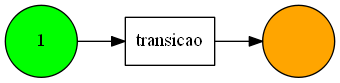

In [61]:
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [60]:
net, initial_marking, final_marking = pnml_importer.apply('petri.pnml')

In [63]:
pnml_exporter.apply(net, initial_marking, "petri.pnml")